In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir))

# from utils.preprocess import *
# from utils.model import *
# from utils.train import *

In [3]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False

    # Data config
    imgconf_file: str = '../data/VinBigData/train.csv'
    imgdir_name: str = "../data/VinBigData/png256"
    seed: int = 111
    n_splits: int = 5

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [4]:
# !pip install pip install iterative-stratification
# # https://pypi.org/project/iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


class MultilabelKFoldWrapper:
    NOFINDING = 14
    
    def __init__(self, train: pd.DataFrame, n_splits: int, seed: int):
        if self.NOFINDING in train['class_id'].unique():
            self.train = train.query(f'class_id != {self.NOFINDING}').reset_index(drop=True)
            print(f'Removing class_id = {self.NOFINDING}: {train.shape[0]} → {self.train.shape[0]}')
        else:
            self.train = train
        self.classes = [f'class_{i}' for i in range(14)]

        self.n_splits = n_splits
        self.seed = seed
        
        self.annot_pivot = None
        self.stats = None
        
        self.__i = -1
        self.__split()
    
    def __iter__(self):
        self.__i = -1
        return self
    
    def __next__(self):
        self.__i += 1
        if self.__i < 0 or self.n_splits <= self.__i:
            raise StopIteration()
        return self.__getitem__(idx=self.__i)
    
    def __len__(self) -> int:
        return self.n_splits
    
    def __getitem__(self, idx: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        if idx < 0 or self.n_splits <= idx:
            raise ValueError()
        return self.train.query(f'fold != {idx}').reset_index(drop=True), self.train.query(f'fold == {idx}').reset_index(drop=True)
    
    def __split(self) -> None:
        kf = MultilabelStratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
        self.train['id'] = self.train.index
        annot_pivot = pd.pivot_table(self.train, index='image_id', columns='class_id', values='id', fill_value=0, aggfunc='count').reset_index().rename_axis(None, axis=1)
        annot_pivot = annot_pivot.rename(columns={i: cls_nm for i, cls_nm in enumerate(self.classes)})

        annot_pivot['fold'] = -1
        for fold, (train_idx, valid_idx) in enumerate(kf.split(annot_pivot, annot_pivot.loc[:, self.classes])):
            annot_pivot.loc[valid_idx, 'fold'] = fold
        
        self.annot_pivot = annot_pivot
        self.stats = self.annot_pivot.groupby('fold').sum().reset_index()
        
        self.train = pd.merge(self.train, self.annot_pivot, how='left', on='image_id').drop(columns=['id'] + self.classes)
    
    def plot_stats(self) -> None:
        fig, axes = plt.subplots(1, 5, figsize=(25, 6))
        cols = self.stats.columns[1:-1]
        for fold, ax in enumerate(axes):
            ax.bar(cols, self.stats.loc[fold, cols], tick_label=cols)
            ax.set_title(f'fold = {fold}')
        plt.show()

In [5]:
config = Config()

In [6]:
train = pd.read_csv(str(base_dir / config.imgconf_file))

In [7]:
mkf = MultilabelKFoldWrapper(train=train, n_splits=config.n_splits, seed=config.seed)

Removing class_id = 14: 67914 → 36096


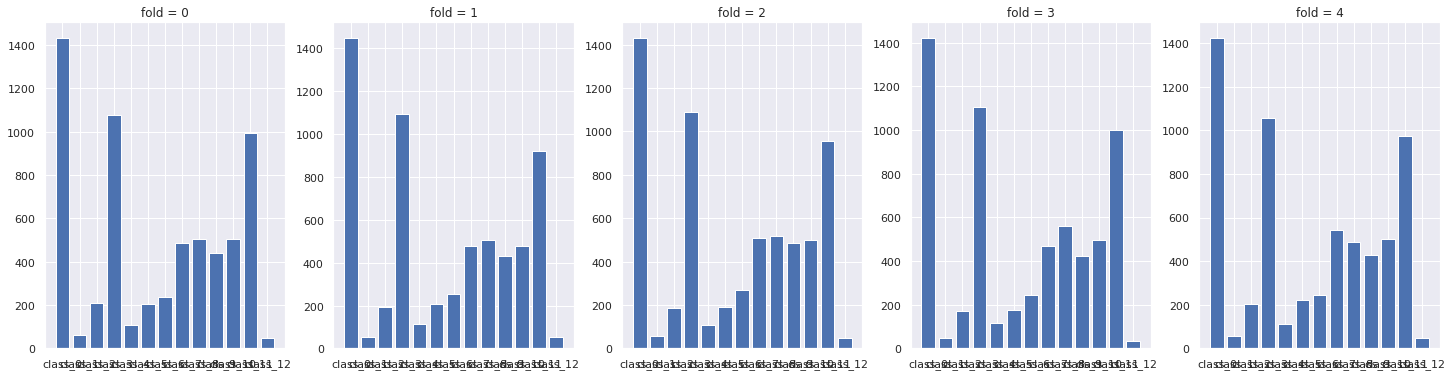

In [8]:
mkf.plot_stats()

In [9]:
for fold, (train_df, valid_df) in enumerate(mkf):
    print(fold)

0
1
2
3
4
